### Partie 3 : Analyse exploratoire (2-3h)

**Competence evaluee : C2.3 - Analyser des donnees structurees pour repondre a un besoin metier**

#### Etape 3.1 : Statistiques descriptives
- Calculer les statistiques par type d'energie, type de batiment et commune
- Identifier les batiments les plus/moins energivores
- Calculer la repartition des consommations par classe energetique DPE
- Analyser l'evolution temporelle (tendances mensuelles, saisonnalite)
- Comparer la consommation theorique (selon DPE) vs reelle

**Livrables** :
- Notebook `06_statistiques_descriptives.ipynb`
- Tableaux de synthese exportes en CSV

Classement DPE : https://www.engie-homeservices.fr/dossiers/connaitre-et-comprendre-les-differentes-classes-dpe
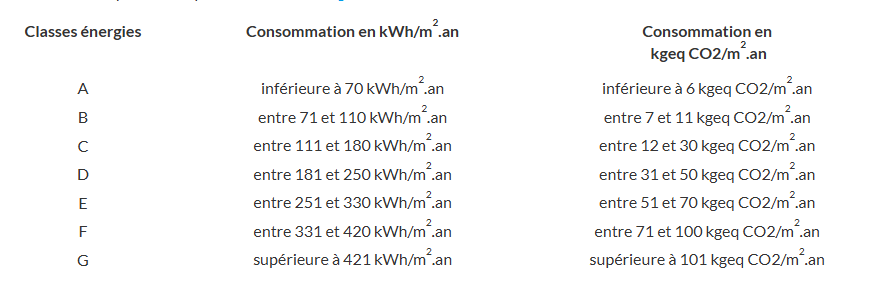

In [ ]:
# - Calculer les statistiques par type d'energie, type de batiment et commune

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder \
    .master("local") \
    .appName("06_statistiques_descriptibes") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# Imports

df = spark.read \
          .option("header", "true") \
          .option("inferSchema", "true") \
          .option("sep", ",") \
          .csv("/output/consommations_enrichies.csv")

df.show(5)

# - Identifier les batiments les plus/moins energivores

df = df.groupBy("type_energie", "type", "commune", "ipe").agg(F.round(F.sum("consommation"), 2).alias("consommation_totale_kWh"))

print("Batiments les moins energivores")
df.orderBy(F.asc("consommation_totale_kWh")).show(10)
print("Batiments les plus energivores")
df.orderBy(F.desc("consommation_totale_kWh")).show(10)

# - Calculer la repartition des consommations par classe energetique DPE    

df = df.withColumn(
    "classe_energetique",
    F.when(F.col("ipe") <= 70, "A")
     .when((F.col("ipe") > 71) & (F.col("ipe") <= 110), "B")
     .when((F.col("ipe") > 111) & (F.col("ipe") <= 180), "C")
     .when((F.col("ipe") > 181) & (F.col("ipe") <= 250), "D")
     .when((F.col("ipe") > 251) & (F.col("ipe") <= 330), "E")
     .when((F.col("ipe") > 331) & (F.col("ipe") <= 420), "F")
     .otherwise("G")
)

print("Repartition des classe energetique DPE")
df.show(5)

# - Analyser l'evolution temporelle (tendances mensuelles, saisonnalite)
# df = df.groupBy("mois").agg(F.sum("consommation").alias("total_consommation"))
# df.show(10)

df_to_pandas = df.toPandas()
df_to_pandas.to_csv("/output/tableau_de_synthese.csv", index=False)

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/c:/Users/Administrateur/Desktop/Github/ECF2/output/fusion_enrichissement.